In [1]:
#pip install nltk
#!pip install optuna

In [2]:
# Import the necessary modules
from fastai.text.all import *
import torch
from zipfile import ZipFile
import os
import pandas as pd
from IPython.display import display,HTML
from sklearn.metrics import confusion_matrix
from fastai.basics import set_seed
import optuna
import warnings

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
"""
references:
1. https://www.linkedin.com/advice/0/how-can-you-tune-neural-networks-dropout-rate-xj2rf
2. https://optuna.org/
3. https://medium.com/ai%C2%B3-theory-practice-business/awd-lstm-6b2744e809c5
4. https://www.geeksforgeeks.org/awd-lstm-unraveling-the-secrets-of-dropconnect-in-lstm/
5. https://www.linkedin.com/advice/1/how-can-you-use-bayesian-optimization-improve-machine-zymlf
6. https://www.sciencedirect.com/science/article/pii/S1674862X19300047
7. ChatGPT
"""

In [4]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
"""
Reference: https://github.com/fastai/fastai/issues/2832
"""
def set_seed(x=42):
    random.seed(x)
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

set_seed()

In [6]:
# Check if the cuda service is available
print (torch.cuda.is_available())

True


In [7]:
"""
import the dataset from Kaggle
"""
dataset_owner = "yasserh"
dataset_name = "twitter-tweets-sentiment-dataset"

# Use the Kaggle API to download the dataset
os.system(f'kaggle datasets download -d {dataset_owner}/{dataset_name}')

# Unzip the downloaded file
with ZipFile(f'{dataset_name}.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Tweets.csv')

In [8]:
# Check the dataset
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [9]:
# Check the shape of the dataset

df.shape

(27481, 4)

In [10]:
# Check whether or not the dataset is balanced
df.loc[:,'sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [11]:
# Check how many words are in one cell
df_word_count = pd.Series()

df['text'] = df['text'].astype(str)
df_word_count = df['text'].apply(lambda x: len(x.split()))

df_word_count_average = df_word_count.mean()
df_word_count_max = np.max(df_word_count)

df_word_count_average
df_word_count_max

np.int64(33)

In [12]:
# Employ word tokenizer
spacy = WordTokenizer()
tkn = Tokenizer(spacy)

# Check if it's working
print(coll_repr(tkn(df.iloc[0,1]), 31))
"""
# Check if it's working
toks = first(spacy([df.iloc[1:4,1]]))

# Print the result
print(coll_repr(toks, 30))
"""

(#10) ['xxbos','xxmaj','i`d','have','responded',',','if','i','were','going']


"\n# Check if it's working\ntoks = first(spacy([df.iloc[1:4,1]]))\n\n# Print the result\nprint(coll_repr(toks, 30))\n"

In [13]:
# Tokenise the dataset
toks = pd.Series()

for post in range(200):
    x = tkn(df.iloc[post, 1])
    toks = pd.concat([toks, pd.Series(x)], axis=0, ignore_index=True)

print(toks)

0           xxbos
1           xxmaj
2             i`d
3            have
4       responded
          ...    
3609      replies
3610        don`t
3611         turn
3612           up
3613            !
Length: 3614, dtype: object


In [14]:
# Tokenisation
print(coll_repr(toks), 31)

(#3614) ['xxbos','xxmaj','i`d','have','responded',',','if','i','were','going'...] 31


In [15]:
# Tokenize corpus
toks200 = df.iloc[0:200,1].map(tkn)
toks200[0]

(#10) ['xxbos','xxmaj','i`d','have','responded',',','if','i','were','going']

In [16]:
# Create a numericalize object
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

"(#216) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','i','.','!','to',',','the','a','and','my','…','?'...]"

In [17]:
# Convert tokens into corresponding numerical encoding
nums = num(toks)[:20]; nums

TensorText([  2,   8, 127,  33,   0,  13,  60,   9, 128,  45,   2,  85,   5,
             29,  46,   7, 100,   9,  76,  86])

In [18]:
# Check that they map back to the original text
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj i`d have xxunk , if i were going xxbos s xxrep 3 o xxup sad i will miss'

In [19]:
# Map the num function to each element in the toks200 list
nums200 = toks200.map(num)

In [20]:
# Create an instance of a "LMDataLoader"
dl = LMDataLoader(nums200)

In [21]:
# Check the first element in dl
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 56]), torch.Size([64, 56]))

In [22]:
# Change the data type for the following code
df['text'] = df['text'].astype(str)

# Create an instance of a "DataBlock"
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),  # Use the column "text" to create a text block
    get_items=lambda x: x['text'].tolist(),  # Extract the column "text" and change it to a list
    splitter=RandomSplitter(0.2, seed=42)  # Split the dataset randomly
).dataloaders(df, bs=128, seq_len=33)  # Use the "df" dataset

In [23]:
# Show the batches
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos i got a text from this guy who i don`t like , and who has the same name as the guy i do ! xxmaj how xxunk ! xxbos xxmaj why do","i got a text from this guy who i don`t like , and who has the same name as the guy i do ! xxmaj how xxunk ! xxbos xxmaj why do none"
1,wars xxmaj day xxrep 3 ! xxmaj may xxmaj the 4th xxmaj be xxmaj with xxmaj you ! xxbos awake and ready to learn a little more xxbos xxunk .. weather man ..,xxmaj day xxrep 3 ! xxmaj may xxmaj the 4th xxmaj be xxmaj with xxmaj you ! xxbos awake and ready to learn a little more xxbos xxunk .. weather man .. don`t


In [24]:
# Define an objective function
def objective(trial):
    
    # Select learning rate, dropout rate, and batch size to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # Use a log-uniform distribution to select the learning rate
    dropout = trial.suggest_float ('dropout', 0.1, 0.5)  # Use a uniform distribution to select the dropout rate
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16) # Select the batch size from the number 16 to 256, with step equal to 16

    # Use the selected batch size to build a model
    dls_lm.bs = batch_size
    
    # Create an instance of "language_model_learner"
    learn = language_model_learner(
        dls_lm, AWD_LSTM, drop_mult=dropout,  # Configure the dropout rate
        metrics=[accuracy, Perplexity()]).to_fp16() 
    
    # Train the model
    learn.fit_one_cycle(1, lr)  # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_before_1 = optuna.create_study(direction='minimize')
study_before_1.optimize(objective, n_trials=10)

[I 2024-11-17 17:15:48,624] A new study created in memory with name: no-name-b0e33a32-84e9-4f30-bf5a-7258931d9c37


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.397622,5.012101,0.176180,150.219971,01:25


[I 2024-11-17 17:17:30,966] Trial 0 finished with value: 5.012100696563721 and parameters: {'lr': 0.0016556197300253766, 'dropout': 0.47203280234764, 'batch_size': 208}. Best is trial 0 with value: 5.012100696563721.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.941784,5.761013,0.153353,317.669983,01:24


[I 2024-11-17 17:19:12,076] Trial 1 finished with value: 5.761013031005859 and parameters: {'lr': 0.0002447524470469161, 'dropout': 0.24731202844054567, 'batch_size': 176}. Best is trial 0 with value: 5.012100696563721.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.517416,4.246168,0.230735,69.837257,01:16


[I 2024-11-17 17:20:44,335] Trial 2 finished with value: 4.2461676597595215 and parameters: {'lr': 0.039946217684289784, 'dropout': 0.12398390690142046, 'batch_size': 192}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.504940,5.221612,0.171620,185.232529,01:44


[I 2024-11-17 17:22:47,040] Trial 3 finished with value: 5.221611976623535 and parameters: {'lr': 0.001042558970267854, 'dropout': 0.24066938414105268, 'batch_size': 160}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.587289,4.260201,0.228065,70.824219,01:22


[I 2024-11-17 17:24:25,581] Trial 4 finished with value: 4.2602009773254395 and parameters: {'lr': 0.03925959365295973, 'dropout': 0.40576607789336305, 'batch_size': 80}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.543902,4.285295,0.225792,72.623932,01:19


[I 2024-11-17 17:26:01,395] Trial 5 finished with value: 4.285294532775879 and parameters: {'lr': 0.015513899186166063, 'dropout': 0.10009826718828596, 'batch_size': 16}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.035899,5.859885,0.149359,350.683716,01:21


[I 2024-11-17 17:27:39,635] Trial 6 finished with value: 5.859884738922119 and parameters: {'lr': 0.00015077030901185757, 'dropout': 0.3268615586630411, 'batch_size': 64}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.087054,5.915699,0.147572,370.813416,01:29


[I 2024-11-17 17:29:28,151] Trial 7 finished with value: 5.915699005126953 and parameters: {'lr': 9.873234792825088e-05, 'dropout': 0.31542435734689067, 'batch_size': 176}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.839819,4.478629,0.210071,88.113754,01:29


[I 2024-11-17 17:31:14,214] Trial 8 finished with value: 4.478628635406494 and parameters: {'lr': 0.005321575200593292, 'dropout': 0.303488354161665, 'batch_size': 96}. Best is trial 2 with value: 4.2461676597595215.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.654075,5.410497,0.165039,223.742798,01:19


[I 2024-11-17 17:32:49,364] Trial 9 finished with value: 5.410497188568115 and parameters: {'lr': 0.0006904917410327947, 'dropout': 0.20486502408190208, 'batch_size': 240}. Best is trial 2 with value: 4.2461676597595215.


In [25]:
# Obtain the optimal hyperparameters
best_params_before_1 = study_before_1.best_params
print(best_params_before_1)

{'lr': 0.039946217684289784, 'dropout': 0.12398390690142046, 'batch_size': 192}


In [26]:
# Change the data type for the following code
df['text'] = df['text'].astype(str)

# Create an instance of a "DataBlock"
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),  # Use the column "text" to create a text block
    get_items=lambda x: x['text'].tolist(),  # Extract the column "text" and change it to a list
    splitter=RandomSplitter(0.2, seed=42)  # Split the dataset randomly
).dataloaders(df, bs=best_params_before_1['batch_size'], seq_len=33)  # Use the "df" dataset

In [27]:
# Create an instance of "language_model_learner"
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=best_params_before_1['dropout'], 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [28]:
# Get access to the GPU service
if torch.cuda.is_available() == True:
  learn.model = learn.model.to('cuda')
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [29]:
# Fit the model
learn.fit_one_cycle(1, best_params_before_1['lr'])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.573491,4.265144,0.229635,71.175156,01:18


In [30]:
# Save the model
learn.save('1epoch')

Path('models/1epoch.pth')

In [31]:
# Load the model
learn = learn.load('1epoch')

In [32]:
# Define an objective function
def objective(trial):

    # Select learning rate to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)  # Use a log-uniform distribution to select the learning rate
    
    # Train the model
    learn.unfreeze()
    learn.fit_one_cycle(1, lr)  # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_before_2 = optuna.create_study(direction='minimize')
study_before_2.optimize(objective, n_trials=10)

[I 2024-11-17 17:34:54,893] A new study created in memory with name: no-name-4e7c9b07-5352-4432-b678-450a97857972


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.096203,4.250412,0.233195,70.134270,01:20


[I 2024-11-17 17:36:30,379] Trial 0 finished with value: 4.250411510467529 and parameters: {'lr': 3.27355793913464e-05}. Best is trial 0 with value: 4.250411510467529.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.060460,4.225969,0.236727,68.440781,01:20


[I 2024-11-17 17:38:05,930] Trial 1 finished with value: 4.225968837738037 and parameters: {'lr': 9.201993702093303e-05}. Best is trial 1 with value: 4.225968837738037.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.030715,4.212310,0.238727,67.512337,01:32


[I 2024-11-17 17:39:58,247] Trial 2 finished with value: 4.212310314178467 and parameters: {'lr': 6.91579922889594e-05}. Best is trial 2 with value: 4.212310314178467.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.016084,4.210539,0.238763,67.392876,01:22


[I 2024-11-17 17:41:36,294] Trial 3 finished with value: 4.2105393409729 and parameters: {'lr': 1.2971330522387126e-05}. Best is trial 3 with value: 4.2105393409729.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.018304,4.208826,0.239098,67.277512,01:18


[I 2024-11-17 17:43:08,995] Trial 4 finished with value: 4.208826065063477 and parameters: {'lr': 1.0605882322122315e-05}. Best is trial 4 with value: 4.208826065063477.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.005998,4.202708,0.240148,66.867180,01:16


[I 2024-11-17 17:44:40,235] Trial 5 finished with value: 4.2027082443237305 and parameters: {'lr': 4.7019634662422075e-05}. Best is trial 5 with value: 4.2027082443237305.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.998993,4.198545,0.240374,66.589401,01:15


[I 2024-11-17 17:46:10,771] Trial 6 finished with value: 4.198545455932617 and parameters: {'lr': 3.0154984030866465e-05}. Best is trial 6 with value: 4.198545455932617.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.993608,4.196040,0.240940,66.422783,01:17


[I 2024-11-17 17:47:42,824] Trial 7 finished with value: 4.196040153503418 and parameters: {'lr': 1.939561257308846e-05}. Best is trial 7 with value: 4.196040153503418.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.976504,4.185460,0.242517,65.723701,01:17


[I 2024-11-17 17:49:15,360] Trial 8 finished with value: 4.185459613800049 and parameters: {'lr': 9.575837475479106e-05}. Best is trial 8 with value: 4.185459613800049.


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.963940,4.182446,0.242570,65.525932,01:14


[I 2024-11-17 17:50:44,453] Trial 9 finished with value: 4.182446002960205 and parameters: {'lr': 4.312716336917812e-05}. Best is trial 9 with value: 4.182446002960205.


In [33]:
# Obtain the optimal hyperparameters
best_params_before_2 = study_before_2.best_params
print(best_params_before_2)

{'lr': 4.312716336917812e-05}


In [34]:
# Unfreeze all the layers
learn.unfreeze()

# Fit the model
learn.fit_one_cycle(10, best_params_before_2['lr'])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.954609,4.181934,0.242649,65.492386,01:18
1,3.954610,4.177576,0.243750,65.207573,01:14
2,3.941579,4.171001,0.244417,64.780258,01:16
3,3.928938,4.166822,0.244878,64.510109,01:16
4,3.914215,4.163391,0.245301,64.289131,01:21
5,3.903256,4.161245,0.245446,64.151337,01:18
6,3.889626,4.160277,0.246041,64.089264,01:28
7,3.883363,4.159825,0.245904,64.060303,01:39
8,3.875377,4.159591,0.246136,64.045334,01:30
9,3.871962,4.159682,0.246087,64.051170,01:26


In [35]:
# Save the encoder of the model for later use
# The model not including the final layer is called the encoder
learn.save_encoder('finetuned')

In [36]:
# Extra: Predict the next word
TEXT = "I really had a good day yesterday"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [37]:
# Print the results
print("\n".join(preds))

i really had a good day yesterday . i got through a bit of therapy . But still a bit … i have a fever . Ugh … it really sucks . Just found out that i aren`t eating big chocolates and no
i really had a good day yesterday ! Ppl have to drive in , but i want to get some sleep My hubby has a fever It`s all in the same mood ! Good night ! No one was


In [38]:
# Change the data type for the following code
df['text'] = df['text'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)

# Create an instance of a "DataBlock"
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),  # Use the column "text" to create a text block
    get_x=lambda x: x['text'],  # Extract the column "text" and assign it to be an independent feature
    get_y=lambda x: x['sentiment'],  # Extract the column "sentiment" and assign it to be a dependent feature
    splitter=RandomSplitter(0.2, seed=42)  # Split the dataset randomly
).dataloaders(df, bs=128, seq_len=33)  # Use the "df" dataset

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [39]:
# Define an objective function
def objective(trial):
    
    # Select learning rate, dropout rate, and batch size to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # Use a log-uniform distribution to select the learning rate
    dropout = trial.suggest_float ('dropout', 0.1, 0.5)  # Use a uniform distribution to select the dropout rate
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)  # Select the batch size from the number 16 to 256, with step equal to 16

    # Use the selected batch size to build a model
    dls_clas.bs = batch_size
    
    # Create an instance of "language_model_learner"
    learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=dropout, 
                                    metrics=accuracy).to_fp16()
    
    # Train the model
    learn.fit_one_cycle(1, lr)  # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_after_1 = optuna.create_study(direction='minimize')
study_after_1.optimize(objective, n_trials=10)

[I 2024-11-17 18:04:55,654] A new study created in memory with name: no-name-dd7e51c0-474c-476d-a2c3-987847c6005e


epoch,train_loss,valid_loss,accuracy,time
0,1.135204,1.069695,0.440138,01:11


[I 2024-11-17 18:06:21,179] Trial 0 finished with value: 1.0696947574615479 and parameters: {'lr': 2.909085265679418e-05, 'dropout': 0.2510116236651406, 'batch_size': 128}. Best is trial 0 with value: 1.0696947574615479.


epoch,train_loss,valid_loss,accuracy,time
0,0.979985,0.922230,0.570961,01:10


[I 2024-11-17 18:07:48,367] Trial 1 finished with value: 0.9222299456596375 and parameters: {'lr': 0.0002678937288624061, 'dropout': 0.24990479606432967, 'batch_size': 240}. Best is trial 1 with value: 0.9222299456596375.


epoch,train_loss,valid_loss,accuracy,time
0,0.965985,0.893974,0.589520,01:16


[I 2024-11-17 18:09:21,218] Trial 2 finished with value: 0.8939740061759949 and parameters: {'lr': 0.02148699114590522, 'dropout': 0.4607597699675934, 'batch_size': 48}. Best is trial 2 with value: 0.8939740061759949.


epoch,train_loss,valid_loss,accuracy,time
0,1.045568,0.967067,0.536572,01:20


[I 2024-11-17 18:10:59,717] Trial 3 finished with value: 0.9670669436454773 and parameters: {'lr': 0.000205367571023649, 'dropout': 0.49541815818995516, 'batch_size': 160}. Best is trial 2 with value: 0.8939740061759949.


epoch,train_loss,valid_loss,accuracy,time
0,0.912504,0.857468,0.601710,01:14


[I 2024-11-17 18:12:31,046] Trial 4 finished with value: 0.857467532157898 and parameters: {'lr': 0.011813107657183632, 'dropout': 0.16250210533226667, 'batch_size': 96}. Best is trial 4 with value: 0.857467532157898.


epoch,train_loss,valid_loss,accuracy,time
0,0.928342,0.860497,0.601164,01:10


[I 2024-11-17 18:13:58,608] Trial 5 finished with value: 0.8604971170425415 and parameters: {'lr': 0.021573469591882926, 'dropout': 0.22626114792400298, 'batch_size': 208}. Best is trial 4 with value: 0.857467532157898.


epoch,train_loss,valid_loss,accuracy,time
0,0.950815,0.877981,0.597889,01:07


[I 2024-11-17 18:15:23,041] Trial 6 finished with value: 0.8779811263084412 and parameters: {'lr': 0.0018568209045635128, 'dropout': 0.2536009982150277, 'batch_size': 128}. Best is trial 4 with value: 0.857467532157898.


epoch,train_loss,valid_loss,accuracy,time
0,1.013446,0.960092,0.544578,01:18


[I 2024-11-17 18:16:59,039] Trial 7 finished with value: 0.9600921869277954 and parameters: {'lr': 0.00015275925251317287, 'dropout': 0.12224800030716315, 'batch_size': 96}. Best is trial 4 with value: 0.857467532157898.


epoch,train_loss,valid_loss,accuracy,time
0,0.958636,0.893406,0.581514,01:17


[I 2024-11-17 18:18:30,229] Trial 8 finished with value: 0.8934056758880615 and parameters: {'lr': 0.007287088216258592, 'dropout': 0.42769050951512455, 'batch_size': 32}. Best is trial 4 with value: 0.857467532157898.


epoch,train_loss,valid_loss,accuracy,time
0,0.940042,0.878759,0.588792,01:03


[I 2024-11-17 18:19:45,259] Trial 9 finished with value: 0.8787586092948914 and parameters: {'lr': 0.0026237356099100065, 'dropout': 0.28575087743427896, 'batch_size': 112}. Best is trial 4 with value: 0.857467532157898.


In [40]:
# Obtain the optimal hyperparameters
best_params_after_1 = study_after_1.best_params
print(best_params_after_1)

{'lr': 0.011813107657183632, 'dropout': 0.16250210533226667, 'batch_size': 96}


In [41]:
# Change the data type for the following code
df['text'] = df['text'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)

# Create an instance of a "DataBlock"
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),  # Use the column "text" to create a text block
    get_x=lambda x: x['text'],  # Extract the column "text" and assign it to be an independent feature
    get_y=lambda x: x['sentiment'],  # Extract the column "sentiment" and assign it to be a dependent feature
    splitter=RandomSplitter(0.2, seed=42)  # Split the dataset randomly
).dataloaders(df, bs=best_params_after_1['batch_size'], seq_len=33)  # Use the "df" dataset

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [42]:
# Create an instance of "language_model_learner"
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=best_params_after_1['dropout'], 
                                metrics=accuracy).to_fp16()

In [43]:
# Load the encoder of the model created above
# The model not including the final layer is called the encoder
learn = learn.load_encoder('finetuned')

In [44]:
# Fit the model
learn.fit_one_cycle(1, best_params_after_1['lr'])

epoch,train_loss,valid_loss,accuracy,time
0,0.813540,0.774889,0.646834,01:14


In [45]:
# Define an objective function
def objective(trial):

    # Select learning rate to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # Use a log-uniform distribution to select the learning rate
    
    # Train the model
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, lr)  # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_after_2 = optuna.create_study(direction='minimize')
study_after_2.optimize(objective, n_trials=10)

[I 2024-11-17 18:21:19,351] A new study created in memory with name: no-name-1a03689c-5ad1-48d3-b2f2-e0b655aacd6a


epoch,train_loss,valid_loss,accuracy,time
0,0.768778,0.757242,0.664847,01:10


[I 2024-11-17 18:22:42,723] Trial 0 finished with value: 0.7572416663169861 and parameters: {'lr': 7.023307908087507e-05}. Best is trial 0 with value: 0.7572416663169861.


epoch,train_loss,valid_loss,accuracy,time
0,0.767034,0.752778,0.663755,01:08


[I 2024-11-17 18:24:05,297] Trial 1 finished with value: 0.7527782917022705 and parameters: {'lr': 1.5989210129426346e-05}. Best is trial 1 with value: 0.7527782917022705.


epoch,train_loss,valid_loss,accuracy,time
0,0.745737,0.696252,0.692686,01:07


[I 2024-11-17 18:25:26,044] Trial 2 finished with value: 0.6962518095970154 and parameters: {'lr': 0.002188058648873176}. Best is trial 2 with value: 0.6962518095970154.


epoch,train_loss,valid_loss,accuracy,time
0,0.672173,0.688553,0.697598,01:07


[I 2024-11-17 18:26:46,927] Trial 3 finished with value: 0.6885528564453125 and parameters: {'lr': 0.00010278821369975859}. Best is trial 3 with value: 0.6885528564453125.


epoch,train_loss,valid_loss,accuracy,time
0,0.693865,0.640941,0.730713,01:04


[I 2024-11-17 18:28:05,547] Trial 4 finished with value: 0.6409409046173096 and parameters: {'lr': 0.004023962628249797}. Best is trial 4 with value: 0.6409409046173096.


epoch,train_loss,valid_loss,accuracy,time
0,0.580551,0.639611,0.730713,01:12


[I 2024-11-17 18:29:33,326] Trial 5 finished with value: 0.6396113634109497 and parameters: {'lr': 1.2893715432360974e-05}. Best is trial 5 with value: 0.6396113634109497.


epoch,train_loss,valid_loss,accuracy,time
0,0.587662,0.637808,0.730531,01:07


[I 2024-11-17 18:30:51,512] Trial 6 finished with value: 0.6378077864646912 and parameters: {'lr': 2.7055686352333943e-05}. Best is trial 6 with value: 0.6378077864646912.


epoch,train_loss,valid_loss,accuracy,time
0,0.565387,0.638511,0.734898,00:56


[I 2024-11-17 18:31:58,520] Trial 7 finished with value: 0.6385111808776855 and parameters: {'lr': 0.0008003788517901672}. Best is trial 6 with value: 0.6378077864646912.


epoch,train_loss,valid_loss,accuracy,time
0,0.515682,0.641017,0.735444,00:56


[I 2024-11-17 18:33:06,041] Trial 8 finished with value: 0.6410172581672668 and parameters: {'lr': 0.00014566479776900948}. Best is trial 6 with value: 0.6378077864646912.


epoch,train_loss,valid_loss,accuracy,time
0,0.612931,0.634226,0.734716,01:01


[I 2024-11-17 18:34:19,261] Trial 9 finished with value: 0.6342259645462036 and parameters: {'lr': 0.005397892164157083}. Best is trial 9 with value: 0.6342259645462036.


In [46]:
# Obtain the optimal hyperparameters
best_params_after_2 = study_after_2.best_params
print(best_params_after_2)

{'lr': 0.005397892164157083}


In [47]:
# Unfreeze a layer
learn.freeze_to(-2)

# Fit the model
learn.fit_one_cycle(1, best_params_after_2['lr'])

epoch,train_loss,valid_loss,accuracy,time
0,0.569734,0.630786,0.741266,00:57


In [48]:
# Define an objective function
def objective(trial):
    
    # Select learning rate to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)  # Use a log-uniform distribution to select the learning rate
    
    # Train the model
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, lr)  # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_after_3 = optuna.create_study(direction='minimize')
study_after_3.optimize(objective, n_trials=10)

[I 2024-11-17 18:35:16,622] A new study created in memory with name: no-name-8da10221-29a4-47f0-af4c-ae09a72794dc


epoch,train_loss,valid_loss,accuracy,time
0,0.434500,0.660052,0.738355,00:58


[I 2024-11-17 18:36:25,916] Trial 0 finished with value: 0.6600522994995117 and parameters: {'lr': 0.000428122443823792}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.343472,0.662234,0.738901,00:59


[I 2024-11-17 18:37:36,539] Trial 1 finished with value: 0.6622343063354492 and parameters: {'lr': 4.016343712471641e-05}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.326007,0.664821,0.738355,00:57


[I 2024-11-17 18:38:44,831] Trial 2 finished with value: 0.6648207902908325 and parameters: {'lr': 1.8029172433398092e-05}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.327742,0.705316,0.732897,00:58


[I 2024-11-17 18:39:55,425] Trial 3 finished with value: 0.7053160071372986 and parameters: {'lr': 0.00026567992657881455}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.265431,0.710004,0.736172,00:59


[I 2024-11-17 18:41:05,754] Trial 4 finished with value: 0.7100043892860413 and parameters: {'lr': 7.950485712414538e-05}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.321334,0.743840,0.726710,00:58


[I 2024-11-17 18:42:15,479] Trial 5 finished with value: 0.7438403964042664 and parameters: {'lr': 0.0009784581730074816}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.206591,0.732471,0.725073,00:57


[I 2024-11-17 18:43:23,613] Trial 6 finished with value: 0.7324712872505188 and parameters: {'lr': 1.2327438059296457e-05}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.209001,0.740576,0.725983,00:59


[I 2024-11-17 18:44:34,396] Trial 7 finished with value: 0.7405755519866943 and parameters: {'lr': 2.870431460274752e-05}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.184820,0.782949,0.726892,00:57


[I 2024-11-17 18:45:43,029] Trial 8 finished with value: 0.7829492092132568 and parameters: {'lr': 0.00014415666284275426}. Best is trial 0 with value: 0.6600522994995117.


epoch,train_loss,valid_loss,accuracy,time
0,0.163282,0.772297,0.723981,00:57


[I 2024-11-17 18:46:51,509] Trial 9 finished with value: 0.7722973823547363 and parameters: {'lr': 1.3492114673500547e-05}. Best is trial 0 with value: 0.6600522994995117.


In [49]:
# Obtain the optimal hyperparameters
best_params_after_3 = study_after_3.best_params
print(best_params_after_3)

{'lr': 0.000428122443823792}


In [50]:
# Unfreeze a layer
learn.freeze_to(-3)

# Fit the model
learn.fit_one_cycle(1, best_params_after_3['lr'])

epoch,train_loss,valid_loss,accuracy,time
0,0.175191,0.854530,0.723071,00:58


In [51]:
# Define an objective function
def objective(trial):
    
    # Select learning rate to optimise
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)  # # Use a log-uniform distribution to select the learning rate
    
    # Train the model
    learn.unfreeze()
    learn.fit_one_cycle(1, lr)  # # Use the selected learning rate to build a model
    
    # Return the loss
    val_loss = learn.validate()[0]
    return val_loss

# Create an optuna to minimise the loss
study_after_4 = optuna.create_study(direction='minimize')
study_after_4.optimize(objective, n_trials=10)

[I 2024-11-17 18:47:49,824] A new study created in memory with name: no-name-976912c2-c45c-4f29-9df9-23d90fc27f7e


epoch,train_loss,valid_loss,accuracy,time
0,0.126005,0.877420,0.721252,00:58


[I 2024-11-17 18:48:59,417] Trial 0 finished with value: 0.8774200677871704 and parameters: {'lr': 9.198107304637114e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.099007,0.904438,0.721252,00:59


[I 2024-11-17 18:50:09,906] Trial 1 finished with value: 0.9044383764266968 and parameters: {'lr': 8.060572989490449e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.091126,0.914473,0.720342,00:59


[I 2024-11-17 18:51:20,024] Trial 2 finished with value: 0.9144734740257263 and parameters: {'lr': 4.480687486714177e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.082463,0.909996,0.718886,01:00


[I 2024-11-17 18:52:31,594] Trial 3 finished with value: 0.9099962711334229 and parameters: {'lr': 9.131369949191708e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.076871,0.968574,0.717977,00:58


[I 2024-11-17 18:53:41,558] Trial 4 finished with value: 0.9685737490653992 and parameters: {'lr': 9.711608658499763e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.065728,0.961870,0.717977,00:59


[I 2024-11-17 18:54:51,339] Trial 5 finished with value: 0.9618702530860901 and parameters: {'lr': 9.209633317393212e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.058931,0.979572,0.718705,00:57


[I 2024-11-17 18:56:00,407] Trial 6 finished with value: 0.9795718789100647 and parameters: {'lr': 1.988532464748644e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.061043,0.976225,0.720342,00:58


[I 2024-11-17 18:57:10,187] Trial 7 finished with value: 0.9762247800827026 and parameters: {'lr': 2.4162305338627124e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.058874,1.009888,0.715793,00:58


[I 2024-11-17 18:58:19,382] Trial 8 finished with value: 1.0098876953125 and parameters: {'lr': 7.808215434878987e-05}. Best is trial 0 with value: 0.8774200677871704.


epoch,train_loss,valid_loss,accuracy,time
0,0.053088,1.016121,0.720706,00:59


[I 2024-11-17 18:59:29,992] Trial 9 finished with value: 1.0161213874816895 and parameters: {'lr': 1.3557217023854202e-05}. Best is trial 0 with value: 0.8774200677871704.


In [52]:
# Obtain the optimal hyperparameters
best_params_after_4 = study_after_4.best_params
print(best_params_after_4)

{'lr': 9.198107304637114e-05}


In [53]:
# Unfreeze all layers
learn.unfreeze()

# Fit the model
learn.fit_one_cycle(20, best_params_after_4['lr'])

epoch,train_loss,valid_loss,accuracy,time
0,0.046290,1.001467,0.720160,00:59
1,0.049499,1.028752,0.718886,00:58
2,0.055946,1.033570,0.720706,01:04
3,0.049220,1.083019,0.720888,01:00
4,0.043487,1.105954,0.719068,00:59
5,0.037867,1.138276,0.721070,00:59
6,0.040083,1.139403,0.717613,01:00
7,0.034267,1.187928,0.719432,01:03
8,0.036122,1.219655,0.712882,01:01
9,0.029629,1.193848,0.718705,01:02


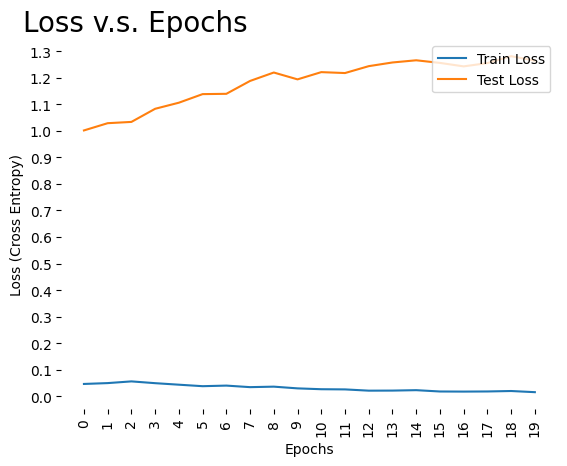

In [54]:
# Visuzlise the loss on the training and testing datasets
for i in range(2):
  plt.plot(L(learn.recorder.values).itemgot(i))
  plt.xticks(range(len(learn.recorder.values)))

  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (Cross Entropy)')
  plt.title('Loss v.s. Epochs', fontsize=20, x=0.15)
  plt.xticks(rotation=90, ha='center')
  plt.yticks(np.arange(0, max(L(learn.recorder.values).itemgot(1)) + 0.1, 0.1))
  ax = plt.gca()
  ax.set_frame_on(False)

In [55]:
# Obtain the predicted values and labels
preds, targs = learn.get_preds()

In [56]:
# Create a list to compare the predicted values for each sample
prediction_list = []

for i, j in enumerate(preds):
    index = torch.argmax(preds[i]).item()
    prediction_list.append(index)

In [57]:
# Convert the labels into a list
targs_list = targs.tolist()

In [58]:
# Build a confusion matrix
cm = confusion_matrix(targs_list, prediction_list)
cm

array([[1069,  449,   55],
       [ 326, 1653,  285],
       [  64,  358, 1237]])

In [59]:
# Convert the confusion matrix into a data frame
cm_pd = pd.DataFrame(cm, columns=np.unique(df.loc[:,'sentiment']), index=np.unique(df.loc[:,'sentiment']))

In [60]:
cm_pd

,negative,neutral,positive
negative,1069,449,55
neutral,326,1653,285
positive,64,358,1237


In [61]:
# Display the layout of the model
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(6168, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(6168, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.06500084213290667, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(


In [62]:
# Create an instance from WordNetLemmatizer, which is for trying to find the root word with linguistics rules (with the use of regexes)
wnl = WordNetLemmatizer()

In [63]:
# Define a function "penn2morphy"
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}  # Create a dictionary to map the keys to values
    try:
        return morphy_tag[penntag[:2]] # If the first two alphabets of the variable match a key in the dictionary, return the corresponding value,
    except:                            # including: n=noun, a=adjective, v=verb, r=adverb. This allows us to know a word's part of speech
        return 'n' # If the first two alphabets are not in the dictionary, return "n" instead, meaning the corresponding word is a noun

In [64]:
# Define a function "lemmatize_sent"
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) #  "penn2morphy(tag)" uses the following second component (tag) 
                                                              #  to run the above function "penn2morphy",
                                                              #  which can know the "part of speech" of each component
                                                              #  "word.lower()" employs the below first component (word). All the words will be
                                                              #  transformed into lowercase.
                                                              #  "wnl.lemmatize" takes two arguments "word.lower()" and "pos=penn2morphy(tag)"
                                                              #  to judge root words
            for word, tag in pos_tag(word_tokenize(text))]  #  The "word_tokenize" function will create a "token" for each word in the argument "text".
                                                            #  The "pos_tag" function will take the "tokens" and return two components. 
                                                            #  The first one is a word in the "text", and will be stored in the variable "word"
                                                            #  and the second one is its corresponding "part of speech". 
                                                            #  e.g., 'PRP', 'VBZ', 'VBG' 'TO', 'NN', and will also be stored in the variable "tag"
    
#  Using a for loop, the "wnl.lemmatize" function will return multiple outputs depending on the length of the argument "text"

In [65]:
# Stopwords from stopwords-json
"""
references: 
1. https://github.com/6/stopwords-json
2. https://www.kaggle.com/code/alvations/basic-nlp-with-nltk
"""
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}

# Identify the stopwords in the json file above, with the use of "set" helps to process faster in Python
stopwords_json_en = set(stopwords_json['en'])

# Identify the stopwords in the nltk module, with the use of "set" helps to process faster in Python
stopwords_nltk_en = set(stopwords.words('english'))

# Identify the punctuation in the string module, with the use of "set" helps to process faster in Python
stopwords_punct = set(punctuation)

# Combine the stopwords for further usage
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [66]:
"""
reference: https://www.kaggle.com/code/alvations/basic-nlp-with-nltk
"""
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas

    # Preprocess text using the "lemmatize_sent" function that just created above
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined  # If a word is in the "stoplist_combined" set, then it will not returned
            and not word.isdigit()] # If a word is a number, then it will not return either

In [67]:
# Split the dataset into dependent and independent features
df_X = df.iloc[:,1]
df_y = df.iloc[:,3]

# Split the dataset into training and testing datasets, with the ratio of 0.8/ 0.2
# The random state guarantees the outcome is reproduceable
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [68]:
"""
reference: https://www.kaggle.com/code/alvations/basic-nlp-with-nltk
"""
# Create an instance of CountVectorizer
# "preprocess_text" is the above function, which serves as the analyzer in this instance
count_vect = CountVectorizer(analyzer=preprocess_text)

# Transform all samples in X_train into a sparse matrix, where rows indicate every sample in X_train, 
# and columns represent the words appearing in all the samples. If this sparse matrix = A, and A[0,1]=1, it means in the first sample, 
# the name of the second column appears once.
train_set = count_vect.fit_transform(X_train)

# Same as above, with different argument
test_set = count_vect.transform(X_test)

In [69]:
"""
reference: https://www.kaggle.com/code/alvations/basic-nlp-with-nltk
"""
# Create an instance of MultinomialNB, a naive Bayes classifier
clf = MultinomialNB() 

# Fit the dependent and independent features in the training data
clf.fit(train_set, y_train) 

MultinomialNB()

In [70]:
"""
reference: https://www.kaggle.com/code/alvations/basic-nlp-with-nltk
"""
# Predict the dependent feature in the testing dataset using the above classifier
predictions_valid = clf.predict(test_set)

# Print the accuracy score
print('The accuracy of the test dataset = {}'.format(
        accuracy_score(predictions_valid, y_test))
     )

The accuracy of the test dataset = 0.6217937056576315


In [71]:
# Build a confusion matrix
cm = confusion_matrix(y_test, predictions_valid)
cm

array([[ 891,  550,  121],
       [ 356, 1445,  429],
       [  68,  555, 1082]])

In [72]:
# Convert the confusion matrix into a data frame
cm_naive_bayes = pd.DataFrame(cm, columns=np.unique(df.loc[:,'sentiment']), index=np.unique(df.loc[:,'sentiment']))
cm_naive_bayes

,negative,neutral,positive
negative,891,550,121
neutral,356,1445,429
positive,68,555,1082
